In [2]:
import pandas as pd 
import json 

from seaborn import heatmap
import matplotlib.pyplot as plt

with open('../probe_results/llama-3.1-8b-instruct_layer25_predictions2.json', 'r') as f:
    f = pd.DataFrame(json.load(f)['predictions'])

In [3]:
f.sort_values(by=['num1', 'num2'], inplace=True)

In [4]:
fstr = f[['num1','num2','string_similarity']]
fint = f[['num1','num2','int_similarity']]


fstr = fstr.pivot(index='num1', columns='num2', values='string_similarity')
fint = fint.pivot(index='num1', columns='num2', values='int_similarity')



In [5]:
fstr = fstr.fillna(0)
fint = fint.fillna(0)



In [20]:
import pickle 

with open('../data/sim_matrix_probe_string.pkl', 'wb') as f:
    pickle.dump(fstr.to_numpy(), f)

with open('../data/sim_matrix_probe_int.pkl', 'wb') as f:
    pickle.dump(fint.to_numpy(), f)




In [7]:
# load in the pickle files 
with open('../data/sim_matrix_probe_string.pkl', 'rb') as f:
    tstr = pickle.load(f)

with open('../data/sim_matrix_probe_int.pkl', 'rb') as f:
    tint = pickle.load(f)


Text(0.5, 1.0, 'String Similarity')

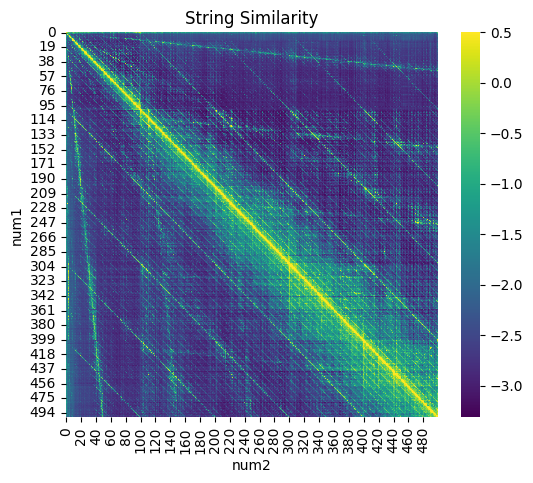

In [6]:
fig, ax = plt.subplots(figsize=(6, 5))
heatmap(fstr, ax=ax, cmap='viridis', vmax=0.5)
ax.set_title('String Similarity')

Text(0.5, 1.0, 'Integer Similarity')

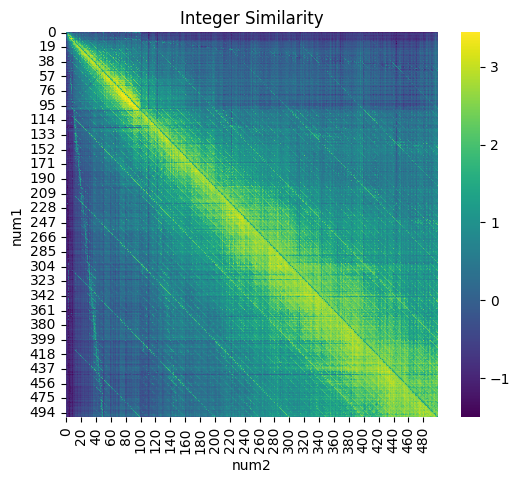

In [7]:
from seaborn import heatmap

fig, ax = plt.subplots(figsize=(6, 5))
heatmap(fint, ax=ax, cmap='viridis')
ax.set_title('Integer Similarity')


### Correlation with the groundtruth linear and levenshtein distance

In [8]:
import pandas as pd
import numpy as np 

import torch as t

import sys
sys.path.append('/scratch/gpfs/vv7118/projects/number_comparison/src/probing')

from create_data import SimilarityData
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('meta-llama/llama-3.1-8b-instruct')

data = SimilarityData(format='string', n_comparisons=None, max_nums=500, seed=42, tokenizer=tokenizer)

0 0
getting dist matrices
got dist matrices


In [9]:
str_groundtruth = data.return_groundtruths(format='string')
int_groundtruth = data.return_groundtruths(format='int')




In [10]:
f['string_groundtruth'] = str_groundtruth
f['int_groundtruth'] = int_groundtruth




In [11]:
str_corr = f[['string_similarity', 'string_groundtruth', 'int_groundtruth']].corr()
int_corr = f[['int_similarity', 'string_groundtruth', 'int_groundtruth']].corr()




In [12]:
str_corr = str_corr.to_dict()
int_corr = int_corr.to_dict()


In [13]:
data_str = {
    'String Probe': str_corr['string_similarity']['string_groundtruth'],
    'Integer Probe': str_corr['string_similarity']['int_groundtruth'],
}

data_int = {
    'String Probe': int_corr['int_similarity']['string_groundtruth'],
    'Integer Probe': int_corr['int_similarity']['int_groundtruth'],
}


In [14]:
data_str

{'String Probe': 0.6497993937680275, 'Integer Probe': 0.5272449100474844}

In [15]:
data_int

{'String Probe': 0.39347821320620985, 'Integer Probe': 0.9165601193926438}

In [59]:
plot_vals_str = pd.Series(data_str)
plot_vals_int = pd.Series(data_int)



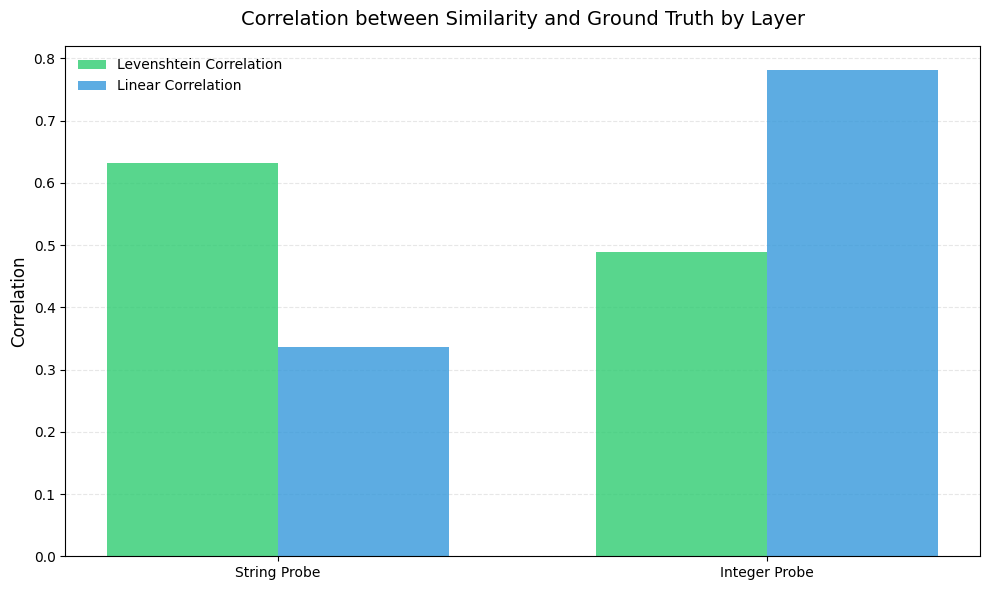

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))

# Set the width of each bar and positions of the bars
width = 0.35
x = np.arange(len(plot_vals_str.index))

# Create the bars
rects1 = ax.bar(x - width/2, plot_vals_str.values, width, label='Levenshtein Correlation', color='#2ecc71', alpha=0.8)
rects2 = ax.bar(x + width/2, plot_vals_int.values, width, label='Linear Correlation', color='#3498db', alpha=0.8)

# Customize the plot
ax.set_ylabel('Correlation', fontsize=12)
ax.set_title('Correlation between Similarity and Ground Truth by Layer', fontsize=14, pad=15)
ax.set_xticks(x)
ax.set_xticklabels(plot_vals_str.index, rotation=0)
ax.legend(frameon=False)

# Add grid for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)  # Place grid below bars

# Adjust layout and save
plt.tight_layout()

,string_similarity,string_groundtruth,int_similarity,int_groundtruth
string_similarity,0.0,0.0,0.0,0.0
string_groundtruth,0.0,0.0,0.0,0.0
int_similarity,0.0,0.0,0.0,0.0
int_groundtruth,0.0,0.0,0.0,0.0


In [16]:
# Get correlation matrix and p-values
from scipy import stats

def get_corr_and_pval(x, y):
    corr, pval = stats.pearsonr(x, y)
    return corr, pval

cols = ['string_similarity', 'string_groundtruth', 'int_similarity', 'int_groundtruth']
n = len(cols)
corr_matrix = np.zeros((n,n))
p_matrix = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        corr, p = get_corr_and_pval(f[cols[i]], f[cols[j]])
        corr_matrix[i,j] = corr
        p_matrix[i,j] = p

corr_matrix = pd.DataFrame(corr_matrix, columns=cols, index=cols).round(3)
p_matrix = pd.DataFrame(p_matrix, columns=cols, index=cols).round(3)

# Create a mask for the upper triangle (excluding diagonal)
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

# Replace upper triangle with '--'
corr_matrix_masked = corr_matrix.copy()
p_matrix_masked = p_matrix.copy()
corr_matrix_masked[mask] = '--'
p_matrix_masked[mask] = '--'

# Format and print correlation matrix with p-values
print("Correlation Matrix:")
print(corr_matrix_masked.apply(lambda x: x.apply(lambda y: '{:.3g}'.format(y) if isinstance(y, float) else y)).to_latex())
print("\nP-values Matrix:")
print(p_matrix_masked.apply(lambda x: x.apply(lambda y: '{:.5g}'.format(y) if isinstance(y, float) else y)).to_latex())

Correlation Matrix:
\begin{tabular}{lllll}
\toprule
 & string_similarity & string_groundtruth & int_similarity & int_groundtruth \\
\midrule
string_similarity & 1 & -- & -- & -- \\
string_groundtruth & 0.65 & 1 & -- & -- \\
int_similarity & 0.667 & 0.393 & 1 & -- \\
int_groundtruth & 0.527 & 0.266 & 0.917 & 1 \\
\bottomrule
\end{tabular}


P-values Matrix:
\begin{tabular}{lllll}
\toprule
 & string_similarity & string_groundtruth & int_similarity & int_groundtruth \\
\midrule
string_similarity & 0 & -- & -- & -- \\
string_groundtruth & 0 & 0 & -- & -- \\
int_similarity & 0 & 0 & 0 & -- \\
int_groundtruth & 0 & 0 & 0 & 0 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3143690/3856380833.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '--' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  corr_matrix_masked[mask] = '--'
/tmp/ipykernel_3143690/3856380833.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '--' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  p_matrix_masked[mask] = '--'


### MDS on the similarity matrix 

In [17]:
import numpy as np 
from sklearn.manifold import MDS
n_components = 2
np.random.seed(42)

dissimilarities_str = {}
dissimilarities_str["Human"] = 1 - (fstr.values + fstr.T.values) / 2

transformed_data_str = {}

for key in dissimilarities_str.keys():
    dissimilarity = dissimilarities_str[key]
    embedding = MDS(n_components=n_components, metric = True, dissimilarity = "precomputed", max_iter = 100, eps = 1e-100)
    init = embedding.fit_transform(dissimilarity)
    embedding = MDS(n_components=n_components, metric = False, dissimilarity = "precomputed", max_iter = 100, eps = 1e-100)
    transformed_data_str[key] = embedding.fit_transform(dissimilarity, init = init)

/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/sklearn/manifold/_mds.py:342: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(


In [18]:
dissimilarities_int = {}
dissimilarities_int["int"] = 1 - (fint.values + fint.T.values) / 2

transformed_data_int = {}

for key in dissimilarities_int.keys():
    dissimilarity = dissimilarities_int[key]
    embedding = MDS(n_components=n_components, metric = True, dissimilarity = "precomputed", max_iter = 100, eps = 1e-100)
    init = embedding.fit_transform(dissimilarity)
    embedding = MDS(n_components=n_components, metric = False, dissimilarity = "precomputed", max_iter = 100, eps = 1e-100)
    transformed_data_int[key] = embedding.fit_transform(dissimilarity, init = init)

/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/sklearn/manifold/_mds.py:342: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(


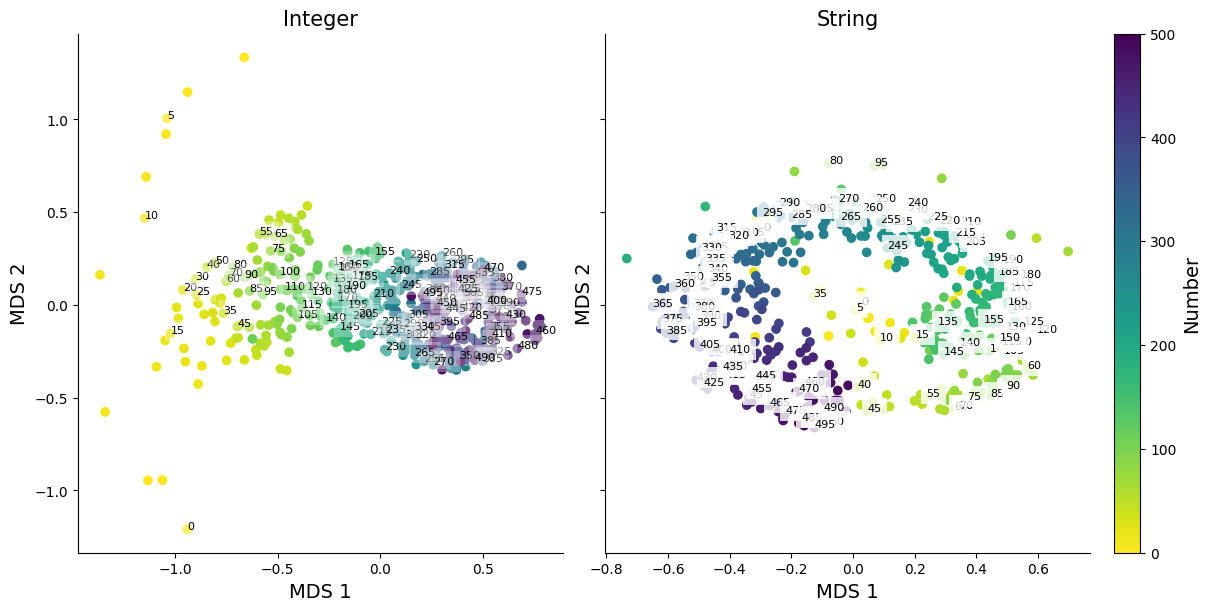

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True, sharey=True)

# Create a colormap
cmap = plt.get_cmap('viridis_r')
norm = plt.Normalize(vmin=0, vmax=500)

# Scatter plot with color based on index
sc = ax1.scatter(
    transformed_data_int['int'][:, 0], 
    transformed_data_int['int'][:, 1], 
    c=np.arange(500),  # Color based on index
    cmap=cmap, 
    norm=norm
)

# Annotate points
for i in range(0, 500, 5):
    ax1.annotate(
        i, 
        (transformed_data_int['int'][i, 0], transformed_data_int['int'][i, 1]),
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.3),
        fontsize=8
    )


ax1.set_title('Integer', fontsize=15)

# Scatter plot with color based on index
sc = ax2.scatter(
    transformed_data_str['Human'][:, 0], 
    transformed_data_str['Human'][:, 1], 
    c=np.arange(500),  # Color based on index
    cmap=cmap, 
    norm=norm
)

# Annotate points
for i in range(0, 500, 5):
    ax2.annotate(
        i, 
        (transformed_data_str['Human'][i, 0], transformed_data_str['Human'][i, 1]),
        bbox=dict(facecolor='white', edgecolor='none', alpha=.8),
        fontsize=8
    )

for ax in [ax1, ax2]:
    ax.set_xlabel('MDS 1', fontsize=14)
    ax.set_ylabel('MDS 2', fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax2.set_title('String', fontsize=15)
# Add a colorbar with custom label
cbar = plt.colorbar(sc, ax=ax2, label='Number')
cbar.set_label('Number', fontsize=14)  # Set fontsize to 14

plt.savefig('../visuals/mds_similarity2.pdf', dpi=300, bbox_inches='tight')
plt.show()